## Importing Libraries


In [1]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime
import cv2
import os
import io
from warnings import filterwarnings

# Colour

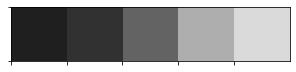

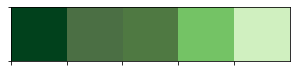

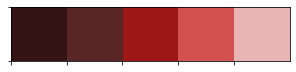

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

## Data Preperation
 
1.   Load all training and testing data

2.   Pre-processing images (apply opencv functions : bilateralFilter,applyColorMap,resize)

3.   Append images and labels into Python list

4.   Convert lists into numpy array and normalize images with devide by 255

5.   One Hot Encoding on the labels

6.   Dividing the dataset into Training and Validation sets





In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('/home/sysadm/Downloads/cleaned/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('/home/sysadm/Downloads/cleaned/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████| 74/74 [00:00<00:00, 617.29it/s]


(4345, 200, 200, 3)
(799, 200, 200, 3)


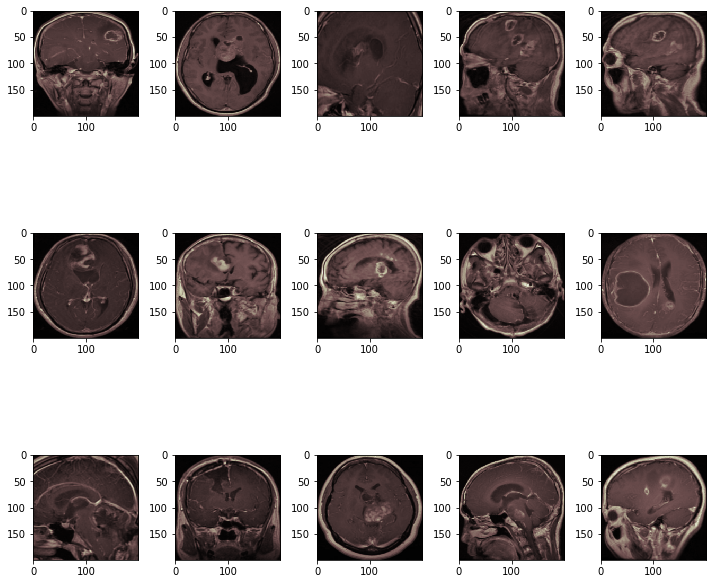

In [5]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [6]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(869, 200, 200, 3)


## Data Augmentation


In [8]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

## Pre-trained Modelintegrated




In [9]:
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

In [10]:
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Training


In [11]:
BATCH_SIZE = 64
EPOCHS = 12

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)


callbacks = [reduce_lr,tensorboard,checkpoint]

history = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),
                    epochs = EPOCHS,callbacks = callbacks)


/home/sysadm/anaconda3/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/12
174/174 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.8682
Epoch 00001: val_accuracy improved from -inf to 0.17722, saving model to resnet.h5
174/174 [==============================] - 587s 3s/step - loss: 0.3718 - accuracy: 0.8682 - val_loss: 7.8056 - val_accuracy: 0.1772 - lr: 1.0000e-04
Epoch 2/12
174/174 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9511
Epoch 00002: val_accuracy did not improve from 0.17722
174/174 [==============================] - 562s 3s/step - loss: 0.1410 - accuracy: 0.9511 - val_loss: 5.0289 - val_accuracy: 0.1772 - lr: 1.0000e-04
Epoch 3/12
174/174 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9698
Epoch 00003: val_accuracy improved from 0.17722 to 0.36709, saving model to resnet.h5
174/174 [==============================] - 558s 3s/step - loss: 0.0895 - accuracy: 0.9698 - val_loss: 2.6329 - val_accuracy: 0.3671 - lr: 1.0000e-04
Epoch 4/12
174/174 [=====================

## Learning curves

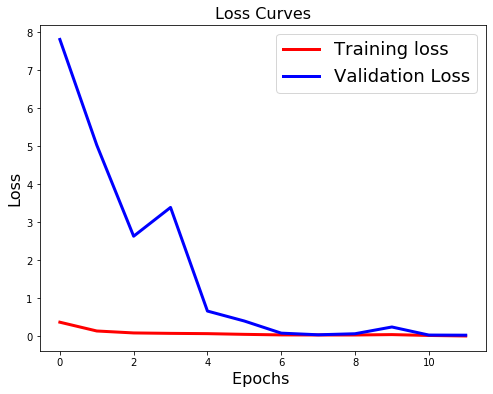

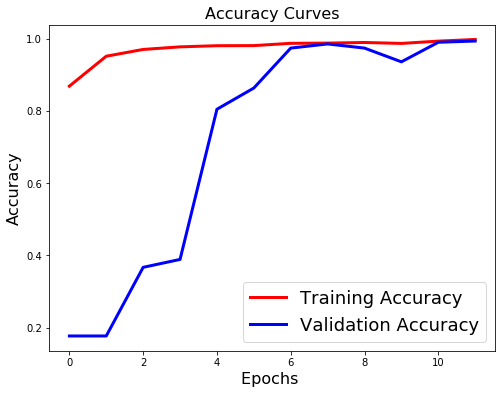

In [12]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

## Evaluation

              precision    recall  f1-score   support

           0       1.00      0.28      0.44       100
           1       0.96      1.00      0.98       510
           2       0.68      1.00      0.81       115
           3       0.94      0.88      0.91        74

    accuracy                           0.90       799
   macro avg       0.89      0.79      0.78       799
weighted avg       0.92      0.90      0.88       799



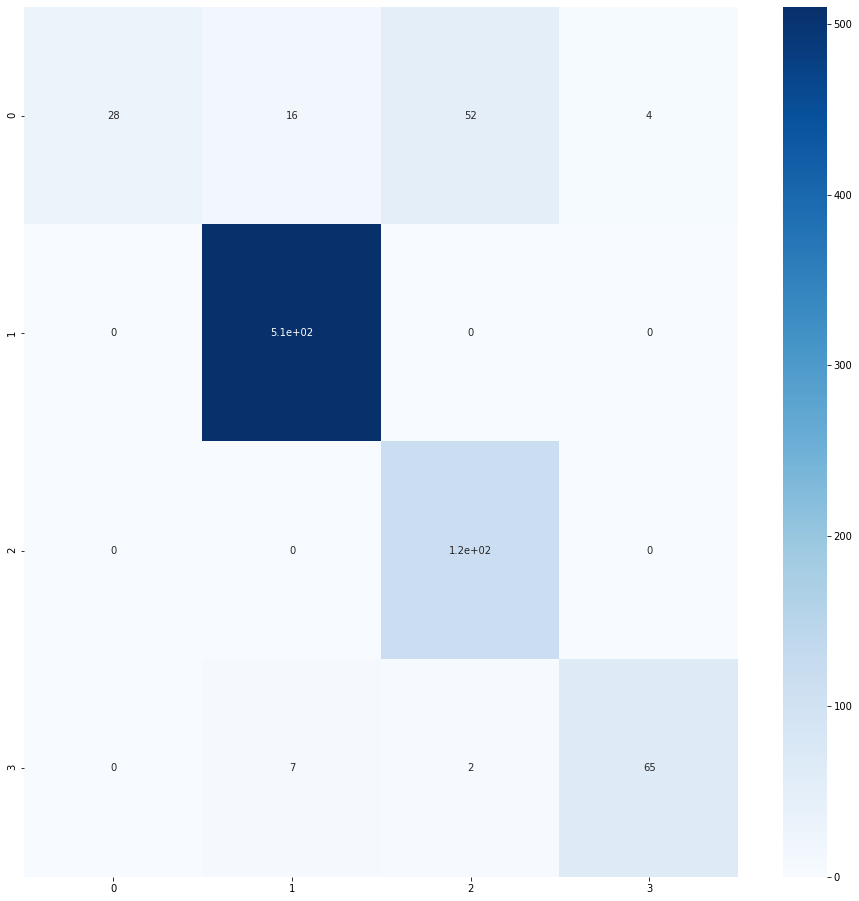

In [13]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

# Testing Accuracy

In [14]:
loss,acc = model.evaluate(x_test,y_test)

25/25 [==============================] - 36s 1s/step - loss: 0.8230 - accuracy: 0.8986
